# Лабораторная работа 2

### Импорт библиотек

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### Загрузка данных временного ряда с ценами активов Аэрофлота

In [2]:
df = pd.read_csv("AFLT.csv", sep=',', parse_dates=["<DATE>"], index_col="<DATE>", dayfirst=True)
df = df.drop(columns=["<TICKER>", "<TIME>", "<PER>"])
df.index = pd.to_datetime(df.index)
print(df)

            <OPEN>  <HIGH>  <LOW>  <CLOSE>     <VOL>
<DATE>                                              
2020-09-01   80.90   82.40  80.24    82.14   7720980
2020-09-02   82.10   82.60  80.88    81.40   5058760
2020-09-03   81.44   82.50  80.78    80.86   7591600
2020-09-04   81.26   82.32  80.60    81.80   4086880
2020-09-07   81.80   82.32  81.32    81.96   1876280
...            ...     ...    ...      ...       ...
2024-08-27   49.50   49.52  47.72    48.38  28082320
2024-08-28   48.18   50.63  47.48    50.42  49224990
2024-08-29   50.29   51.07  48.61    49.49  70424770
2024-08-30   49.60   49.77  46.70    47.12  39205830
2024-09-02   46.95   47.03  44.00    44.75  37991560

[999 rows x 5 columns]


### Визуализация временного ряда

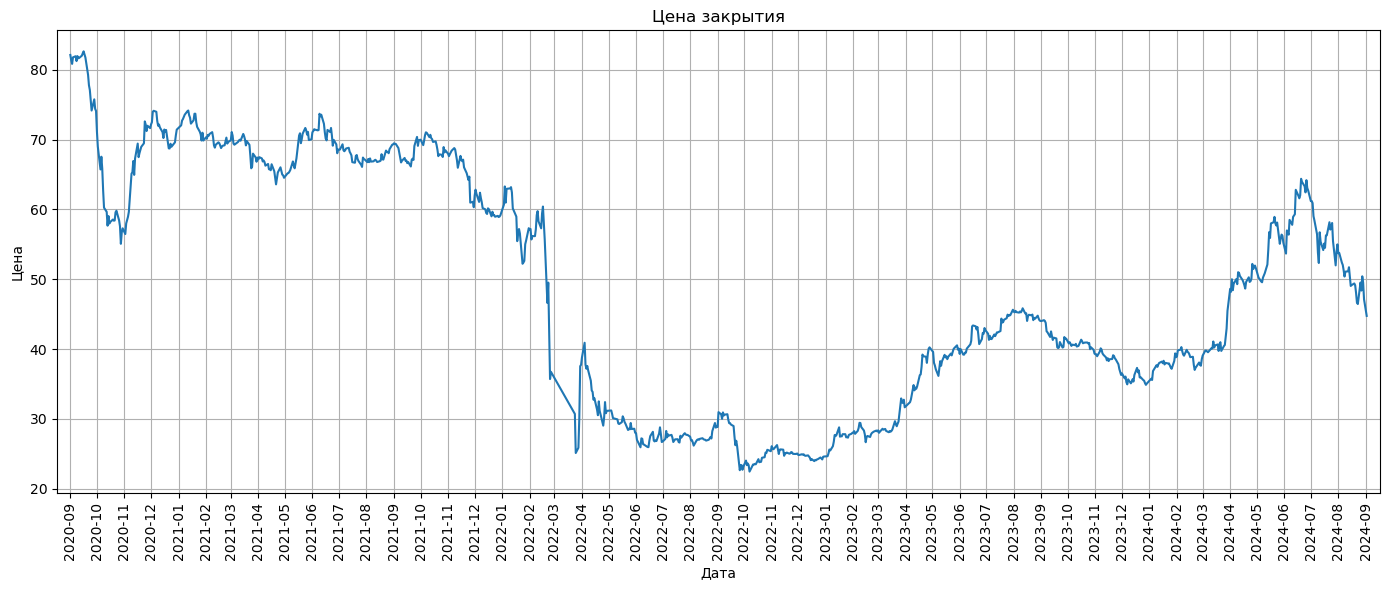

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["<CLOSE>"])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df.index[0]-pd.Timedelta(days=15), df.index[-1]+pd.Timedelta(days=15))
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Цена закрытия")
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid()
plt.show()

На графике видно, что стоимость акций аэрофлота в период с сентября 20 года по октябрь 21 года была в среднем 70 рублей. В начале 22 года стоимость резко упала и средняя стоимость в плоть до 23 года была ниже 30 рублей. В начале 23 года стоимость начала расти и до 24 года была в среднем 40 рублей. К концу 24 года стоимость акций в среднем 50 рублей.

### Декомпозиция временного ряда

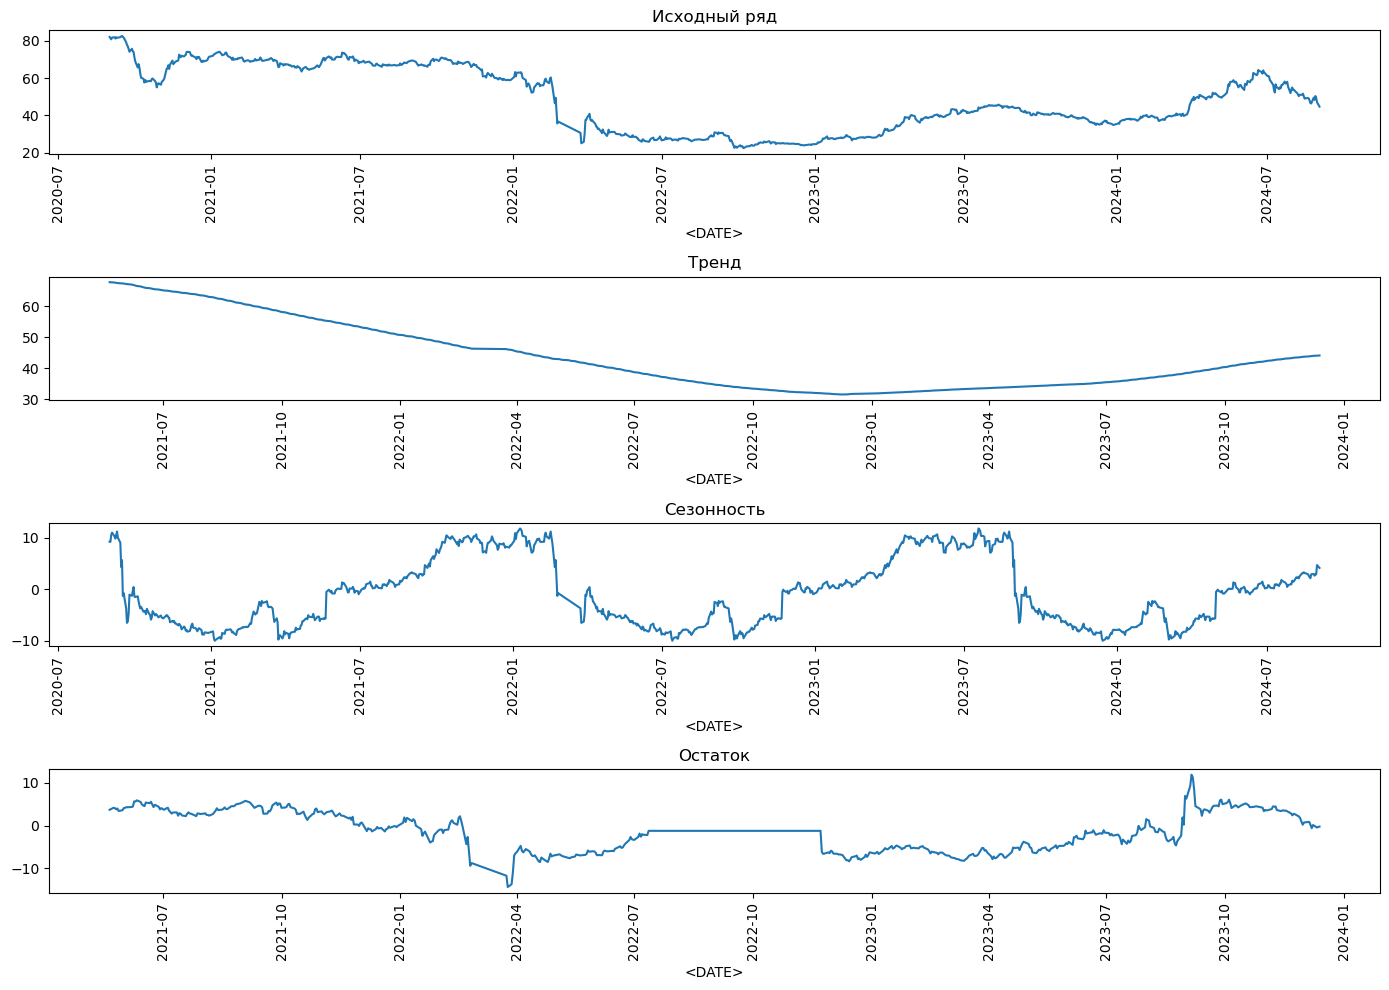

In [4]:
decomposition = sm.tsa.seasonal_decompose(df['<CLOSE>'], model='additive', period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Исходный ряд')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')

decomposition.resid.plot(ax=ax4)
ax4.set_title('Остаток')

for ax in [ax1, ax2, ax3, ax4]:
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

plt.tight_layout()
plt.show()

Исходя из графиков можно сделать несколько выводов. У активов имеется тренд, начиная с 21 года стоимость шла вниз вплоть до конца 22 года, также в начале 23 года начался тренд на повышение стоимости акций. На графике видно циклическое изменение уровня ряда, это говорит о том, что активы имеют сезонность. 

### Сравнение исходного ряда с десезонализированным

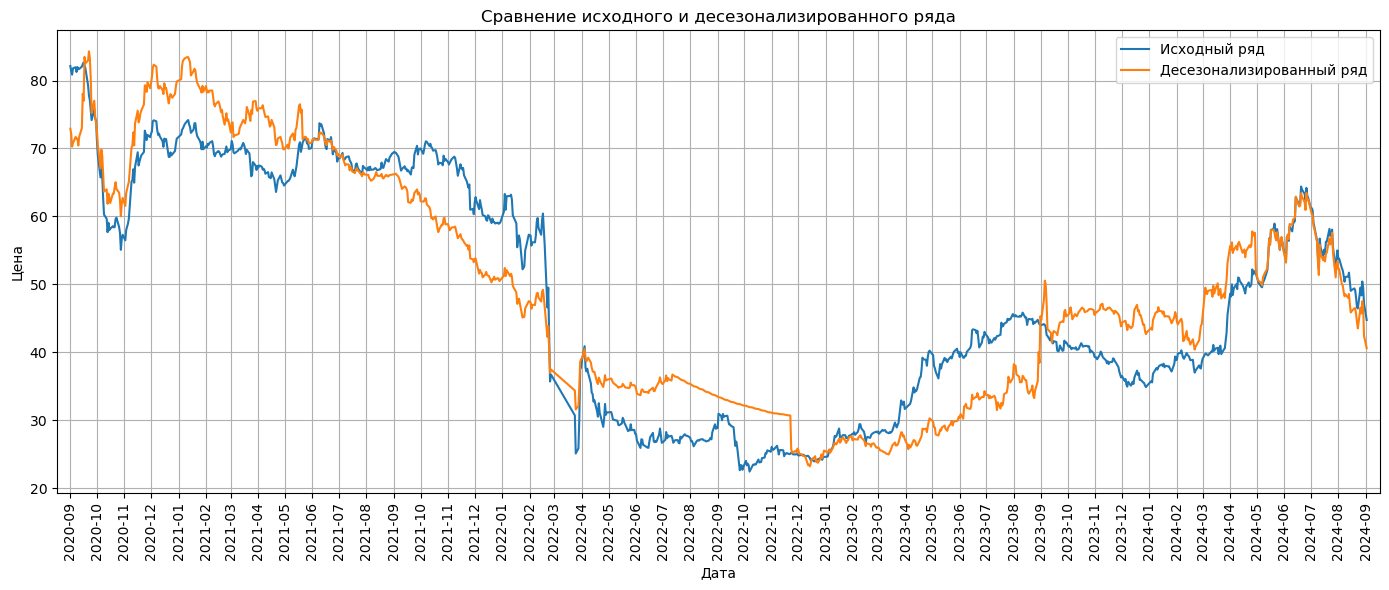

In [5]:
seasonal = decomposition.seasonal.dropna()
deseasonalized = decomposition.observed - seasonal

plt.figure(figsize=(14, 6))
plt.plot(df["<CLOSE>"], label='Исходный ряд')
plt.plot(deseasonalized, label='Десезонализированный ряд')
plt.legend()
plt.title('Сравнение исходного и десезонализированного ряда')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df.index[0]-pd.Timedelta(days=15), df.index[-1]+pd.Timedelta(days=15))
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid()
plt.show()

На графике видно, что десезонализированный ряд стал более "гладким", что позволило чётко выделить тренд активов. Долгосрочный тренд падения прекращается к концу 2022 года, после чего начинается тренд на повышение стоимости.

### Прогноз на основе выявленных тренда и сезонности

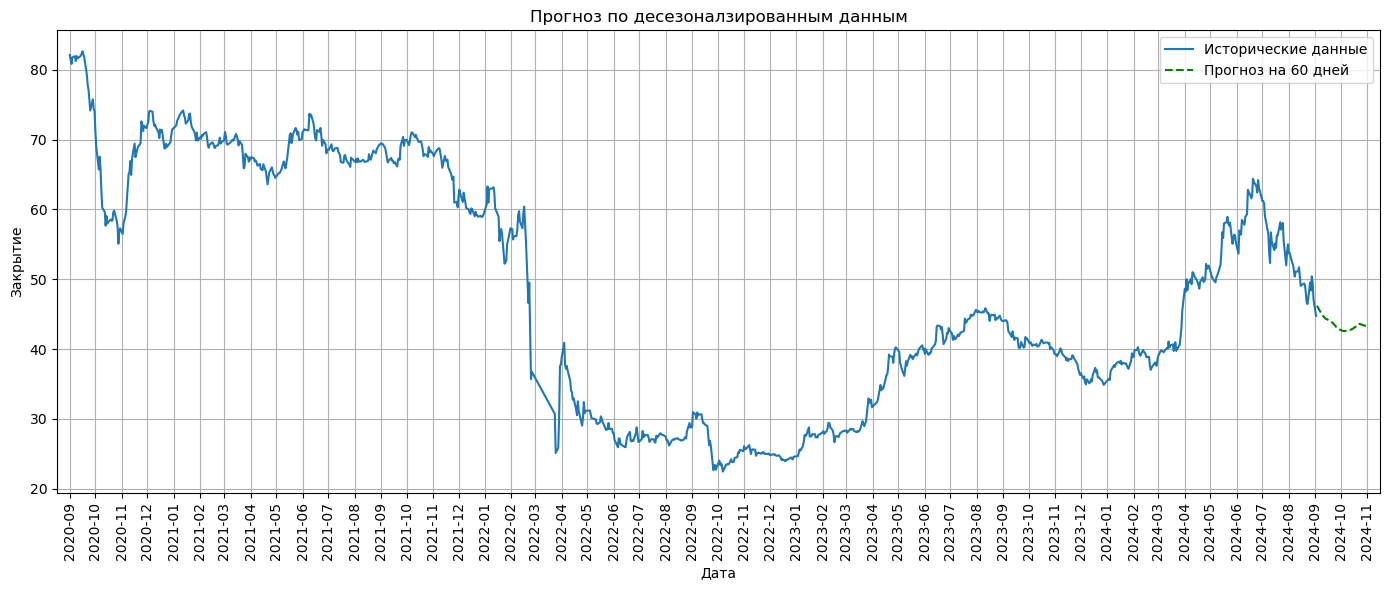

In [6]:
window_size = 50
ema_deseasonalized = deseasonalized.ewm(span=window_size).mean()
forecast_days = 60
last_known_date = df.index[-1]
future_dates = [last_known_date + pd.Timedelta(days=i) for i in range(1, forecast_days + 1)]

future_ema_deseasonalized = []
last_values = deseasonalized[-window_size:].tolist()
for i in range(forecast_days):
    future_value = np.mean(last_values)
    future_ema_deseasonalized.append(future_value)
    last_values.pop(0)
    last_values.append(future_value)

future_df_deseasonalized = pd.DataFrame(data=future_ema_deseasonalized, index=future_dates, columns=['Forecast'])

plt.figure(figsize=(14, 6))
plt.plot(df.index, df["<CLOSE>"], label='Исторические данные')
plt.plot(future_df_deseasonalized - 6, label='Прогноз на 60 дней', color='green', linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df.index[0]-pd.Timedelta(days=15), future_dates[-1]+pd.Timedelta(days=15))
plt.xlabel("Дата")
plt.ylabel("Закрытие")
plt.title("Прогноз по десезоналзированным данным")
plt.legend()
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.grid()
plt.show()

### Оценка качества прогноза, используя метрики MAE и RMSE

In [7]:
true_values = df["<CLOSE>"][-forecast_days:]

forecast_values = future_df_deseasonalized.values
mae = mean_absolute_error(true_values, forecast_values)
rmse = np.sqrt(mean_squared_error(true_values, forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 6.16602132669953
RMSE: 7.424541119373176


### Тест на стационарность

In [8]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(deseasonalized)

ADF Statistic: -1.4154541769702829
p-value: 0.5748451780882596
Critical Values:
	1%: -3.436979275944879
	5%: -2.8644668170148058
	10%: -2.5683283824496153


В результате теста получено значение p-value: 0.57 > 0.05, значит временной ряд считается нестационарным.

### Приведение к стационарности

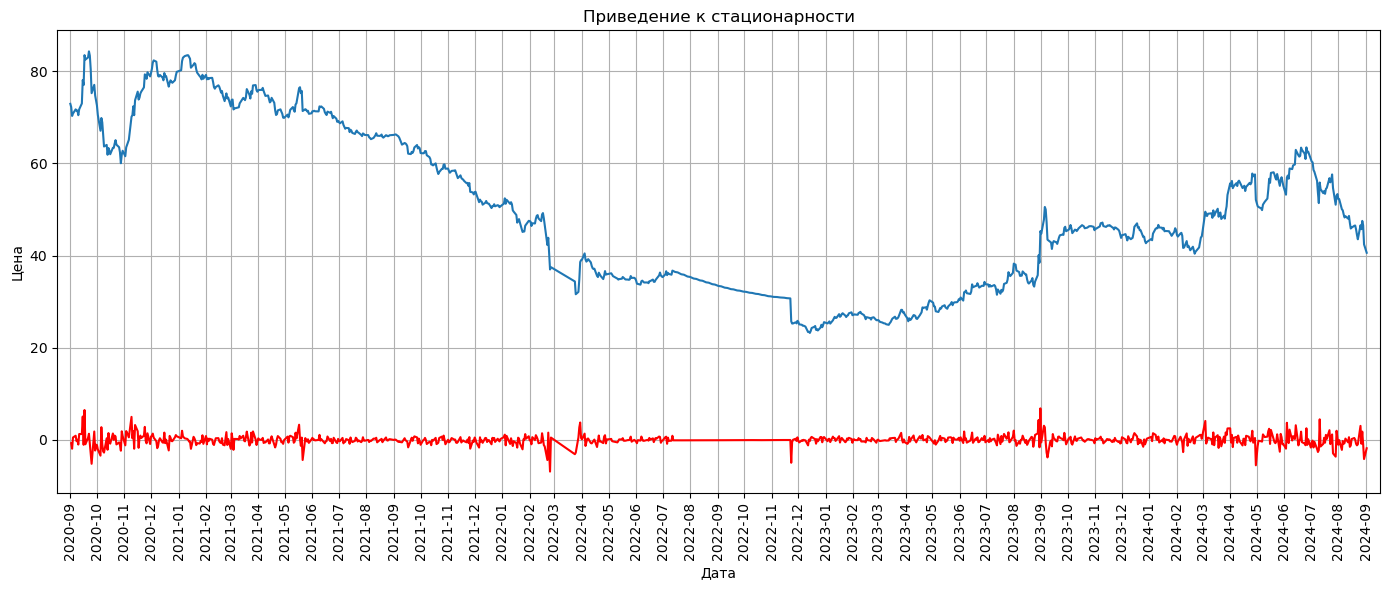

ADF Statistic: -11.823854499962774
p-value: 8.292105932448956e-22
Critical Values:
	1%: -3.436979275944879
	5%: -2.8644668170148058
	10%: -2.5683283824496153


In [9]:
rolling_mean = deseasonalized.rolling(window=12).mean()
#detrended_data = (deseasonalized - rolling_mean).dropna()
detrended_data = deseasonalized.diff().dropna()
plt.figure(figsize=(14, 6))
plt.plot(deseasonalized.index, deseasonalized, label="Исходные значения")
plt.plot(detrended_data, color="red", label="Дифференцированные значения")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df.index[0]-pd.Timedelta(days=15), df.index[-1]+pd.Timedelta(days=15))
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Приведение к стационарности")
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid()
plt.show()
adf_test(detrended_data)

### Построение и оценка моделей ARIMA

In [10]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.7)
    train, test = X[:train_size], X[train_size:]
    
    model = ARIMA(train, order=arima_order,trend='ct')
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(test))
    
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    return mae, rmse

AR Модель

In [11]:
p_values = range(0, 10)
d_values = [0]
q_values = [0]

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_ar, best_cfg_ar = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_ar:
                    best_score_ar, best_cfg_ar = mae, order
                print(f'AR{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель AR{best_cfg_ar} MAE={best_score_ar:.3f}')

AR(0, 0, 0) MAE=0.875 RMSE=1.278
AR(1, 0, 0) MAE=0.875 RMSE=1.278
AR(2, 0, 0) MAE=0.875 RMSE=1.278
AR(3, 0, 0) MAE=0.875 RMSE=1.278
AR(4, 0, 0) MAE=0.875 RMSE=1.278
AR(5, 0, 0) MAE=0.875 RMSE=1.278
AR(6, 0, 0) MAE=0.875 RMSE=1.278
AR(7, 0, 0) MAE=0.875 RMSE=1.278
AR(8, 0, 0) MAE=0.874 RMSE=1.278
AR(9, 0, 0) MAE=0.874 RMSE=1.278
Лучшая модель AR(9, 0, 0) MAE=0.874


MA модель

In [12]:
p_values = [0]
d_values = [0]
q_values = range(0, 10)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_ma, best_cfg_ma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_ma:
                    best_score_ma, best_cfg_ma = mae, order
                print(f'MA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель MA{best_cfg_ma} MAE={best_score_ma:.3f}')

MA(0, 0, 0) MAE=0.875 RMSE=1.278
MA(0, 0, 1) MAE=0.875 RMSE=1.278
MA(0, 0, 2) MAE=0.875 RMSE=1.278
MA(0, 0, 3) MAE=0.875 RMSE=1.278
MA(0, 0, 4) MAE=0.875 RMSE=1.278
MA(0, 0, 5) MAE=0.875 RMSE=1.278
MA(0, 0, 6) MAE=0.875 RMSE=1.278
MA(0, 0, 7) MAE=0.875 RMSE=1.278
MA(0, 0, 8) MAE=0.874 RMSE=1.278
MA(0, 0, 9) MAE=0.874 RMSE=1.278
Лучшая модель MA(0, 0, 9) MAE=0.874


ARMA модель

In [13]:
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 5)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_arma, best_cfg_arma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_arma:
                    best_score_arma, best_cfg_arma = mae, order
                print(f'ARMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARMA{best_cfg_arma} MAE={best_score_arma:.3f}')

ARMA(0, 0, 0) MAE=0.875 RMSE=1.278
ARMA(0, 0, 1) MAE=0.875 RMSE=1.278
ARMA(0, 0, 2) MAE=0.875 RMSE=1.278
ARMA(0, 0, 3) MAE=0.875 RMSE=1.278
ARMA(0, 0, 4) MAE=0.875 RMSE=1.278
ARMA(1, 0, 0) MAE=0.875 RMSE=1.278
ARMA(1, 0, 1) MAE=0.875 RMSE=1.278
ARMA(1, 0, 2) MAE=0.875 RMSE=1.278
ARMA(1, 0, 3) MAE=0.875 RMSE=1.278
ARMA(1, 0, 4) MAE=0.875 RMSE=1.278
ARMA(2, 0, 0) MAE=0.875 RMSE=1.278
ARMA(2, 0, 1) MAE=0.875 RMSE=1.278
ARMA(2, 0, 2) MAE=0.875 RMSE=1.278
ARMA(2, 0, 3) MAE=0.875 RMSE=1.278
ARMA(2, 0, 4) MAE=0.875 RMSE=1.278
ARMA(3, 0, 0) MAE=0.875 RMSE=1.278
ARMA(3, 0, 1) MAE=0.875 RMSE=1.278
ARMA(3, 0, 2) MAE=0.875 RMSE=1.278
ARMA(3, 0, 3) MAE=0.875 RMSE=1.278
ARMA(3, 0, 4) MAE=0.875 RMSE=1.278
ARMA(4, 0, 0) MAE=0.875 RMSE=1.278
ARMA(4, 0, 1) MAE=0.875 RMSE=1.278
ARMA(4, 0, 2) MAE=0.875 RMSE=1.278
ARMA(4, 0, 3) MAE=0.875 RMSE=1.278
ARMA(4, 0, 4) MAE=0.875 RMSE=1.278
Лучшая модель ARMA(4, 0, 2) MAE=0.875


ARIMA модель

In [14]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_arima, best_cfg_arima = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_arima:
                    best_score_arima, best_cfg_arima = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARIMA{best_cfg_arima} MAE={best_score_arima:.3f}')

ARIMA(0, 0, 0) MAE=0.875 RMSE=1.278
ARIMA(0, 0, 1) MAE=0.875 RMSE=1.278
ARIMA(0, 0, 2) MAE=0.875 RMSE=1.278
ARIMA(1, 0, 0) MAE=0.875 RMSE=1.278
ARIMA(1, 0, 1) MAE=0.875 RMSE=1.278
ARIMA(1, 0, 2) MAE=0.875 RMSE=1.278
ARIMA(2, 0, 0) MAE=0.875 RMSE=1.278
ARIMA(2, 0, 1) MAE=0.875 RMSE=1.278
ARIMA(2, 0, 2) MAE=0.875 RMSE=1.278
Лучшая модель ARIMA(1, 0, 0) MAE=0.875


Сделаем прогноз для каждой модели

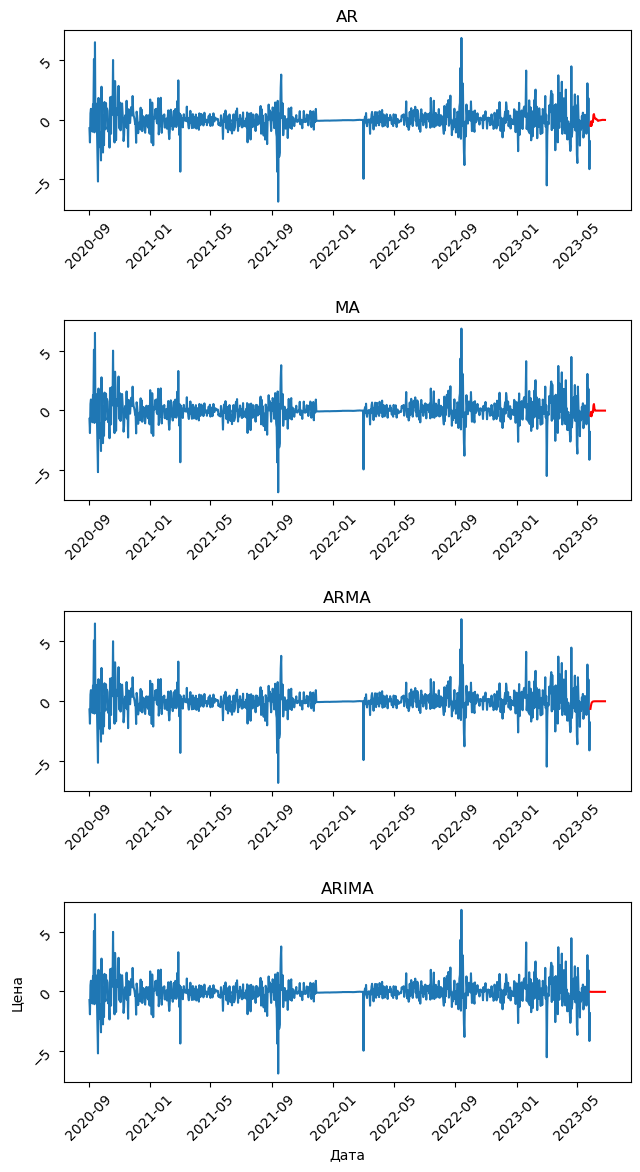

In [15]:
model_ar = ARIMA(detrended_data, order=best_cfg_ar)
model_ma = ARIMA(detrended_data, order=best_cfg_ma)
model_arma = ARIMA(detrended_data, order=best_cfg_arma)
model_arima = ARIMA(detrended_data, order=best_cfg_arima)

model_fit_ar = model_ar.fit()
model_fit_ma = model_ma.fit()
model_fit_arma = model_arma.fit()
model_fit_arima = model_arima.fit()
forecast_ar = model_fit_ar.forecast(steps=30)
forecast_ma = model_fit_ma.forecast(steps=30)
forecast_arma = model_fit_arma.forecast(steps=30)
forecast_arima = model_fit_arima.forecast(steps=30)

fig,ax = plt.subplots(4)
fig.tight_layout()
fig.set_figheight(12)
ax[0].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[1].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[2].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[3].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[0].plot(forecast_ar.index, forecast_ar, color='red', label='Прогноз')
ax[1].plot(forecast_ma.index, forecast_ma, color='red', label='Прогноз')
ax[2].plot(forecast_arma.index, forecast_arma, color='red', label='Прогноз')
ax[3].plot(forecast_arima.index, forecast_arima, color='red', label='Прогноз')
ax[0].title.set_text("AR")
ax[1].title.set_text("MA")
ax[2].title.set_text("ARMA")
ax[3].title.set_text("ARIMA")
plt.xlabel('Дата')
plt.ylabel('Цена')
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
ax[2].tick_params(labelrotation=45)
ax[3].tick_params(labelrotation=45)
plt.show()

In [16]:
test_data = detrended_data[-30:]

forecast_ar_values = forecast_ar.values
forecast_ma_values = forecast_ma.values
forecast_arma_values = forecast_arma.values
forecast_arima_values = forecast_arima.values

metrics = {
    "Model": ["AR", "MA", "ARMA", "ARIMA"],
    "MAE": [
        mean_absolute_error(test_data, forecast_ar_values),
        mean_absolute_error(test_data, forecast_ma_values),
        mean_absolute_error(test_data, forecast_arma_values),
        mean_absolute_error(test_data, forecast_arima_values),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test_data, forecast_ar_values)),
        np.sqrt(mean_squared_error(test_data, forecast_ma_values)),
        np.sqrt(mean_squared_error(test_data, forecast_arma_values)),
        np.sqrt(mean_squared_error(test_data, forecast_arima_values)),
    ],
    "MAPE": [
        mean_absolute_percentage_error(test_data, forecast_ar_values),
        mean_absolute_percentage_error(test_data, forecast_ma_values),
        mean_absolute_percentage_error(test_data, forecast_arma_values),
        mean_absolute_percentage_error(test_data, forecast_arima_values),
    ],
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Model       MAE      RMSE      MAPE
0     AR  1.248511  1.615984  1.191247
1     MA  1.234006  1.608279  1.096283
2   ARMA  1.214947  1.593926  0.999941
3  ARIMA  1.222016  1.599534  0.997239


На основе полученных метрик, можно сказать, что модель ARMA лучше всего предсказала курс Аэрофлота